# Purpose

The purpose of this notebook is to demonstrate prior and predictive checks of one's causal graphical model.

The prior checks are to be used as part of one's falsification efforts before estimating the posterior distribution of one's unknown model parameters. If one's causal model contains latent variables, then such prior checks are expected to be extremely valuable. They are expected to indicate when one's model is likely to poorly fit one's data. This information can be used to avoid a potentially lengthy model estimation process. These checks will likely be implemented with very liberal thresholds for deciding that a model is not even worth beign estimated.

The posterior predictive checks are to really ensure that the observed data is well fit by the assumptions of one's causal model.

# Logical steps
0. Determine the test statistic to be computed.
1. Require as inputs:
   1. predictive samples of all model variables (latent and observed),
   2. function to compute the desired test statistic given a sample from the causal graph,
   3. the observed data.
   4. function to plot the distribution of the simulated test statistic and the value/distribution of the observed test statistic.
2. For each predictive sample,
   1. Compute the value of the simulated and observed test statistic (assuming the observed test statistic also depends on the simulated values. If not, simply store the value of the observed test statistic and do not recompute it.)
   2. Store the simulated and observed test statistics.
3. Visualize the distribution of the simulated and observed test statistics.
4. Produce a scalar summary of the distribution of simulated test statistics if desired.

## Declare notebook parameters

In [1]:
# Declare hyperparameters for testing
NUM_PRIOR_SAMPLES = 100

# Declare the columns to be used for testing
x1_col = 'num_cars'
x2_col = 'num_licensed_drivers'
mode_id_col = 'mode_id'

# Declare paths to data
DATA_PATH =\
    '../../data/raw/spring_2016_all_bay_area_long_format_plus_cross_bay_col.csv'
# Note that these files are based on using the `confounder`
# function from `Causal_Graph_Tim_Data.ipynb`, where the
# confounder function replicates the PPCA model of Wang
# and Blei (2018)
PATH_TO_W_PARAMS = '../../data/processed/W_inferred_PPCA.csv'
PATH_TO_Z_PARAMS = '../../data/processed/Z_inferred_PPCA.csv'

## Execute needed imports

In [2]:
# Built-in modules
import sys

# Third-party modules
import numpy as np
import pandas as pd
from scipy.stats import norm

import seaborn as sbn
import matplotlib.pyplot as plt
%matplotlib inline

# Local modules
sys.path.insert(0, '../../')
import src.viz.sim_cdf as sim_cdf
import src.testing.observable_independence as oi
import src.testing.latent_independence as li
from src.graphs.drive_alone_utility import DRIVE_ALONE_UTILITY
from src.utils import sample_from_factor_model

## Show the motivating causal graph

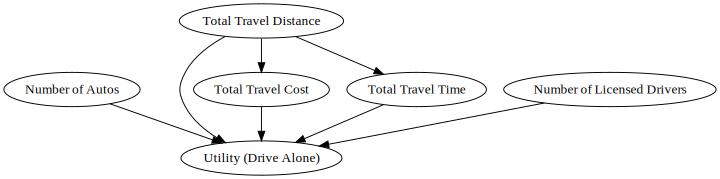

In [3]:
# Draw the causal model motivating this test
causal_graph = DRIVE_ALONE_UTILITY.draw()
causal_graph.graph_attr.update(size="10,6")
causal_graph

## Extract data for the factor model checks

In [4]:
# Load the raw data
df = pd.read_csv(DATA_PATH)

# Create a list of the variables in the drive alone utility
drive_alone_variables =\
    ['total_travel_distance',
     'total_travel_cost',
     'total_travel_time',
     'num_cars',
     'num_licensed_drivers'
    ]

# Create a sub-dataframe with those variables
drive_alone_df =\
    df.loc[df['mode_id'] == 1, drive_alone_variables]

# Get the means and standard deviations of those variables
drive_alone_means = drive_alone_df.mean()
drive_alone_means.name = 'mean'

drive_alone_stds = drive_alone_df.std()
drive_alone_stds.name = 'std'

# Look at the computed means and standard deviations
print(pd.DataFrame([drive_alone_means, drive_alone_stds]).T)

                            mean        std
total_travel_distance  15.579498  18.465879
total_travel_cost       3.289287   4.214448
total_travel_time      29.667137  24.586569
num_cars                2.050999   0.880458
num_licensed_drivers    2.178759   0.751621


## Specify the factor model that is to be checked

In Wang and Blei's deconfounder technique, we fit a factor model to the variables in one's outcome model.

The factor model being considered here is:

$
\begin{aligned}
X_{\textrm{standardized}} &= Z * W + \epsilon\\
\textrm{where } \epsilon &= \left[ \epsilon_1, \epsilon_2, ..., \epsilon_D \right]\\
\epsilon_d &\in \mathbb{R}^{\textrm{N x 1}}\\
\epsilon_d &\sim \mathcal{N} \left(0, \sigma \right) \forall d \in \left\lbrace 1, 2, ... D \right\rbrace\\
Z &\in \mathbb{R}^{\textrm{N x 1}}\\
Z &\sim \mathcal{N} \left(0, 1 \right)\\
W &\in \mathbb{R}^{1 x D}\\
W &\sim \mathcal{N} \left(0, 1 \right)\\
N &= \textrm{Number of rows in X_standardized}\\
D &= \textrm{Number of columns in X_standardized}
\end{aligned}
$

In [5]:
# Note the number of dimensions
num_dimensions = len(drive_alone_variables)

# Specify the prior distributions for the factor
# model of the standardized drive alone dataframe
w_dist_prior = norm(loc=0, scale=1)
z_dist_prior = norm(loc=0, scale=1)

sigma_prior = 0.1
epsilon_dist_prior = norm(loc=0, scale=sigma_prior)

## Generate prior predictive samples

In [6]:
# Get the number of observations for this utility
num_drive_alone_obs = drive_alone_df.shape[0]

# Get samples of x from the prior distribution factor model
x_samples_prior, z_samples_prior =\
    sample_from_factor_model(
        loadings_dist=z_dist_prior,
        coef_dist=w_dist_prior,
        noise_dist=epsilon_dist_prior,
        standard_deviations=drive_alone_stds.values,
        means=drive_alone_means.values,
        num_obs=num_drive_alone_obs,
        num_samples=NUM_PRIOR_SAMPLES,
        num_factors=1,
        seed=721
        )

# Look at the dimensions of the prior predictive samples
print(x_samples_prior.shape)

(3804, 5, 100)


## Visualize the prior predictive distribution

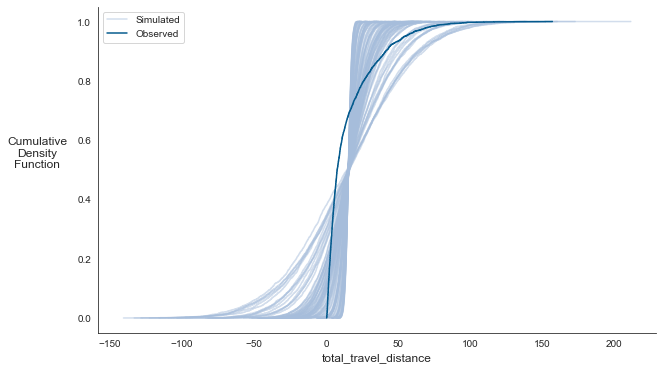

In [7]:
# Choose a column of data to compare
current_col = 0

prior_sim_cdf =\
    li.plot_simulated_vs_observed_cdf(
        drive_alone_df.iloc[:, current_col].values,
        x_samples_prior[:, current_col, :],
        x_label=drive_alone_variables[current_col]
        )

Based on the plot above, it's clear that the currently chosen prior is quite poor.

In other words, there are highly visible levels of prior-data conflict.

This lets us know that the prior predictive check of the deconfounder assumptions is likely to fail since the prior in general is a poor one, even without considering specific checks like conditional independence tests.

### Perform the prior predictive conditional independence test


The p-value of the predictive, permutation C.I.T. is 1.00.


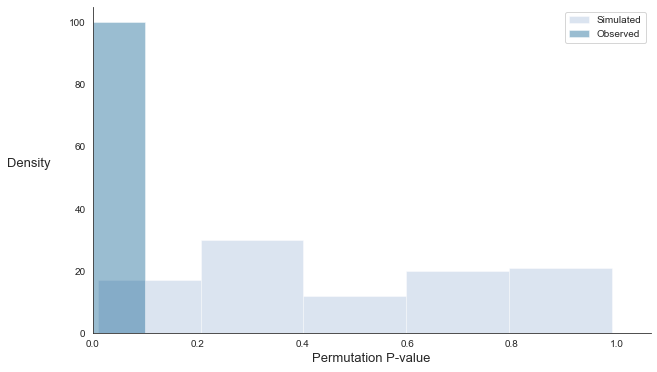

In [8]:
# Collect the columns being used in the test and info about them.
columns_for_test = [x1_col, x2_col]
col_idxs_for_test =\
    [drive_alone_variables.index(col) for col in columns_for_test]

# Get the observed values to be used for testing
obs_sample = drive_alone_df.loc[:, columns_for_test].values

# Get the prior predictive values for testing
prior_samples_triplet =\
    np.concatenate((x_samples_prior[:, col_idxs_for_test, :],
                    z_samples_prior),
                   axis=1)

# Use the predictive, conditional independence test
pval, sampled_pvals, obs_pvals =\
    li.perform_visual_predictive_cit_test(
        prior_samples_triplet,
        obs_sample)

In [9]:
print(obs_pvals)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]


As indicated by the observed p-values, the observed data is strongly refuted (in absolute terms) by a conditional independence test. This is shown by the p-values of zero above.

As indicated by the relative comparison of the observed p-values to the simulated p-values, the p-values generated by the observed data are very different from the p-values generated by the prior (which is known to satisfy the desired conditional independencies).

However, both of these points are somewhat moot since the prior is in general terrible.

## Posterior Predictive Conditional Independence Tests

### Specify the posterior distribution

In [10]:
# Load the parameters of the variational approximation to 
# the posterior distribution over W and Z
w_post_params = pd.read_csv(PATH_TO_W_PARAMS, index_col=0)
z_post_params = pd.read_csv(PATH_TO_Z_PARAMS, index_col=0)

In [11]:
w_post_params['w_var_inferred'] = w_post_params['w_std_inferred']**2
w_post_params

,w_mean_inferred,w_std_inferred,w_var_inferred
0,1.215177,0.006481,0.000042
1,-0.069146,0.006726,0.000045
2,2.085687,0.006190,0.000038
3,-0.325767,0.009528,0.000091
4,-0.330680,0.011007,0.000121


### Generate posterior predictive samples

In [12]:
# Create the posterior distribution of coefficients
# Note we need the arguments to have shape that can,
# be broadcast to (num_factors, num_predictors, num_samples)
w_dist_post =\
    norm(loc=w_post_params['w_mean_inferred'].values[None, : , None],
         scale=w_post_params['w_std_inferred'].values[None :, None])

# Create the posterior distribution of loadings
# Note we need the arguments to have shape that can,
# be broadcast to (num_obs, num_factors, num_samples)
z_dist_post =\
    norm(loc=z_post_params['z_mean_inferred'].values[:, None, None],
         scale=z_post_params['z_std_inferred'].values[:, None, None])

# Get posterior samples of X_standardized
x_samples_post, z_samples_post =\
    sample_from_factor_model(
        loadings_dist=z_dist_post,
        coef_dist=w_dist_post,
        noise_dist=epsilon_dist_prior,
        standard_deviations=drive_alone_stds.values,
        means=drive_alone_means.values,
        num_obs=num_drive_alone_obs,
        num_samples=NUM_PRIOR_SAMPLES,
        num_factors=1,
        post=False,
        seed=852
        )

# Look at the dimensions of the prior predictive samples
print(x_samples_post.shape)

(3804, 5, 100)


### Visualize the posterior predictive distribution

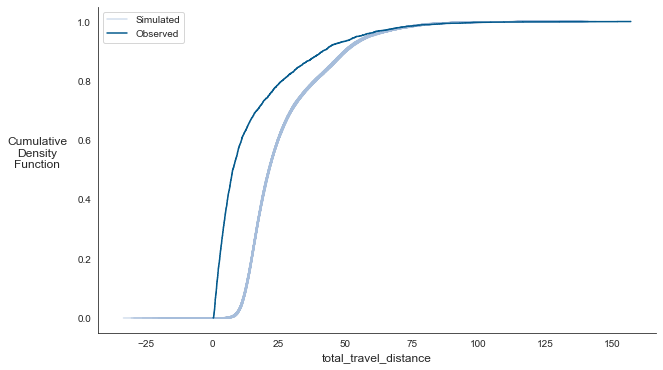

In [13]:
# Choose a column of data to compare
current_col = 0

posterior_sim_cdf =\
    li.plot_simulated_vs_observed_cdf(
        drive_alone_df.iloc[:, current_col].values,
        x_samples_post[:, current_col, :],
        x_label=drive_alone_variables[current_col]
        )

In [14]:
# Compare the observed data with means from
# the prior and posterior distributions.
total_travel_dist_samples =\
    pd.DataFrame({'total_travel_distance_prior':
                      x_samples_prior[:, 0, :].mean(axis=1),
                  'total_travel_distance_post':
                      x_samples_post[:, 0, :].mean(axis=1),
                  'total_travel_distance_obs':
                      drive_alone_df['total_travel_distance'].values})

total_travel_dist_samples.describe()

,total_travel_distance_prior,total_travel_distance_post,total_travel_distance_obs
count,3804.000000,3804.000000,3804.000000
mean,15.600267,26.941085,15.579498
std,1.598061,15.903755,18.465879
min,10.167739,7.585383,0.400000
25%,14.493039,15.718233,3.497500
50%,15.642037,21.176173,7.730000
75%,16.710297,33.555001,21.257500
max,21.380442,136.623651,157.150000


The plot above summarizes the posterior distribution of the total travel distance.
Similar to the prior distribution of the same variable, the posterior poorly fits the data.
As before, we can immediately expect the posterior predictive version of the conditional independence to fail since the observed data is generally unlike the sampled data.
This is dissimilarity is, a-priori, expected to remain in the conditional independence test.

### Perform posterior-predictive conditional independence test


The p-value of the predictive, permutation C.I.T. is 0.99.


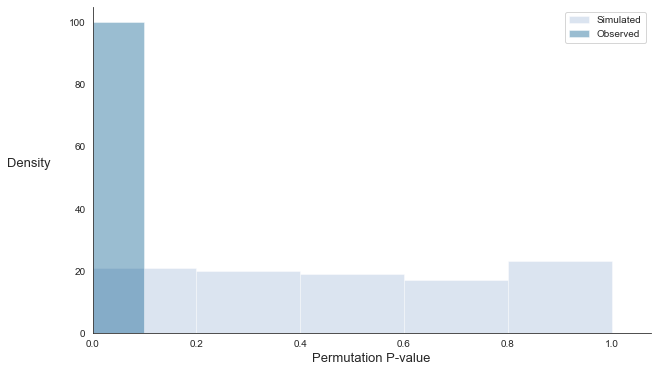

In [15]:
# Get the posterior predictive values for the test
posterior_samples_triplet =\
    np.concatenate((x_samples_post[:, col_idxs_for_test, :],
                    z_samples_post),
                   axis=1)

# Test out the predictive conditional independence test
post_pval, post_sampled_pvals, post_obs_pvals =\
    li.perform_visual_predictive_cit_test(
        posterior_samples_triplet,
        obs_sample)

In [16]:
print(post_obs_pvals)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]


# Test the predictive conditional independence tests
Make sure that the predictive condidtional independence tests are passed when using data that we know satisfies the independence assumptions being tested


The p-value of the predictive, permutation C.I.T. is 0.99.


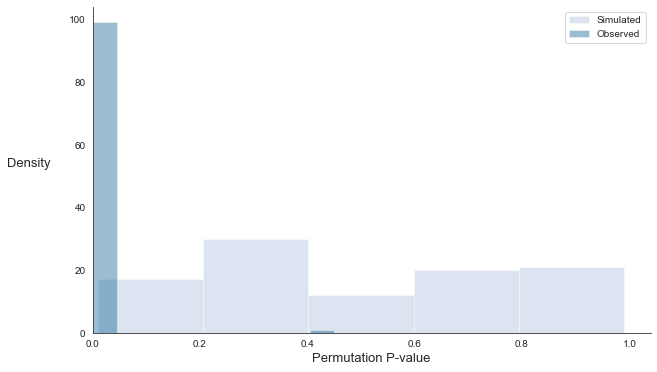

In [17]:
chosen_sim_idx = 50

# Test the predictive C.I.T with a prior sample
prior_sim_sample = x_samples_prior[:, col_idxs_for_test, chosen_sim_idx]
prior_pval_sim, prior_sampled_pvals_sim, prior_obs_pvals_sim =\
    li.perform_visual_predictive_cit_test(
        prior_samples_triplet,
        prior_sim_sample)

In [18]:
prior_sampled_pvals_sim

array([0.09, 0.75, 0.99, 0.34, 0.35, 0.78, 0.51, 0.01, 0.28, 0.37, 0.34,
       0.33, 0.58, 0.15, 0.71, 0.12, 0.31, 0.33, 0.43, 0.17, 0.27, 0.81,
       0.94, 0.54, 0.25, 0.65, 0.38, 0.97, 0.98, 0.91, 0.72, 0.68, 0.83,
       0.78, 0.79, 0.21, 0.01, 0.88, 0.24, 0.64, 0.75, 0.87, 0.08, 0.36,
       0.81, 0.78, 0.17, 0.85, 0.18, 0.08, 0.45, 0.12, 0.29, 0.48, 0.95,
       0.38, 0.26, 0.81, 0.25, 0.21, 0.93, 0.77, 0.61, 0.54, 0.09, 0.38,
       0.57, 0.32, 0.81, 0.7 , 0.91, 0.08, 0.51, 0.4 , 0.71, 0.27, 0.15,
       0.09, 0.62, 0.56, 0.26, 0.4 , 0.29, 0.91, 0.48, 0.09, 0.94, 0.38,
       0.95, 0.05, 0.85, 0.7 , 0.54, 0.35, 0.61, 0.31, 0.38, 0.77, 0.63,
       0.93])

In [19]:
prior_obs_pvals_sim

array([0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.45, 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  ])


The p-value of the predictive, permutation C.I.T. is 0.98.


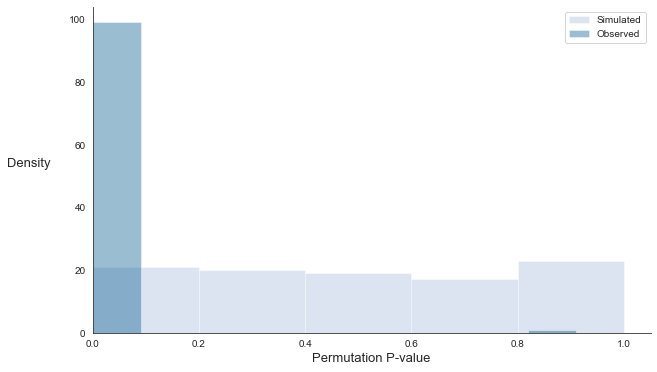

In [20]:
# Test the predictive C.I.T with a posterior sample
post_sim_sample = x_samples_post[:, col_idxs_for_test, chosen_sim_idx]
post_pval_sim, post_sampled_pvals_sim, post_obs_pvals_sim =\
    li.perform_visual_predictive_cit_test(
        posterior_samples_triplet,
        post_sim_sample)

In [21]:
post_sampled_pvals_sim

array([0.02, 0.12, 0.96, 0.78, 0.28, 0.68, 0.58, 0.14, 0.27, 0.19, 0.84,
       0.61, 0.67, 0.21, 0.45, 0.91, 0.1 , 0.93, 0.11, 0.44, 0.67, 0.49,
       0.68, 0.55, 0.14, 0.79, 0.93, 0.2 , 0.83, 0.03, 0.11, 0.1 , 0.46,
       0.45, 0.48, 0.99, 0.68, 0.65, 0.21, 0.72, 0.94, 0.08, 0.31, 0.41,
       0.37, 0.76, 0.49, 0.5 , 0.26, 0.22, 0.91, 0.53, 0.44, 0.4 , 0.28,
       0.22, 0.18, 0.88, 0.13, 0.14, 0.87, 0.93, 0.24, 0.69, 0.  , 0.91,
       0.14, 0.5 , 0.32, 0.89, 0.04, 0.96, 0.71, 0.78, 0.51, 0.37, 0.91,
       0.87, 0.39, 0.55, 0.17, 0.13, 0.57, 0.33, 0.81, 0.35, 0.89, 0.11,
       0.47, 0.91, 0.14, 0.31, 0.62, 0.8 , 0.75, 0.28, 1.  , 0.83, 0.72,
       0.34])

In [22]:
post_obs_pvals_sim

array([0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.91, 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  ])

# Conclusions
From the results above, a few things are apparent.

1. The prior distribution for this particular implementation of the deconfounder is a very poor description of reality. A-priori, our prior beliefs are in severe conflict with our data and are likely in need or revising to be more plausible. For instance, we should never be simulating negative values for `total_travel_distance`.
2. The posterior distribution for this particular implementation of the deconfounder is still a poor description of our data.
3. In order for the predictive conditional independence tests to pass, the inferred latent confounder values must be extremely close to the true latent confounder values. This provides a secondary piece of evidence supporting the finding from Hassan's deconfounder investigation.
   1. The only instance of the test of the deconfounder that succeeded in generating a non-zero p-value (see cell above) is the instance where the value being used as the "observation" was paired with its own latent confounders.
   2. In order for many instances of the test of the deconfounder to succeed in generating non-zero p-values, we'd need most of the simulated latent confounder values to cluster around their true latent confounder values.